# d-separation, Graph Transformation

In a different place, we talked about direction-dependent separation, or [d-separation](http://bayes.cs.ucla.edu/BOOK-2K/d-sep.html). In this notebook, we will explore a different way to compute d-separation based on [graph transformation](https://web.mit.edu/jmn/www/6.034/d-separation.pdf).

## Graph example

Here is a graph taken from this most excellent [video tutorial on d-separation exercises](https://www.youtube.com/watch?v=yDs_q6jKHb0). We will be using this graph to show some d-separation queries.

In [1]:
import networkx as nx
from collections import namedtuple

Graph = namedtuple('Graph', 'u, d')

def get_edges(s):
    edges = s.split('\n')
    edges = map(lambda line: line.split('->'), edges)
    edges = map(lambda tokens: tuple([t.strip() for t in tokens]), edges)
    edges = list(edges)
    
    return edges

def get_directed_graph(edges):
    g = nx.DiGraph()
    g.add_edges_from(edges)
    
    return g

def get_undirected_graph(edges):
    g = nx.Graph()
    g.add_edges_from(edges)
    
    return g

def get_graph(s):
    e = get_edges(s)
    
    d = get_directed_graph(e)
    u = get_undirected_graph(e)
    g = Graph(u, d)
    
    return g

In [2]:
s = '''
U -> W
V -> W
V -> X
V -> T
W -> Y
X -> Y
T -> Z
'''.strip()

g = get_graph(s)

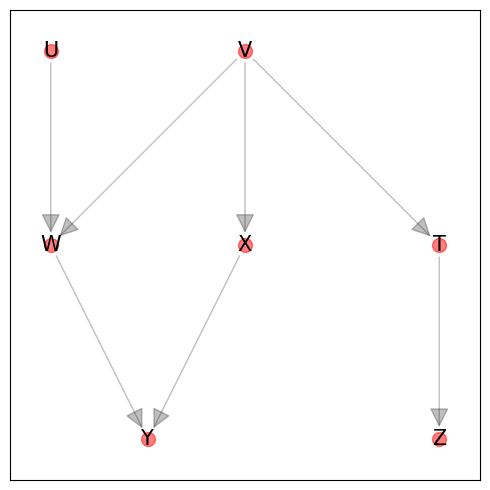

In [3]:
import matplotlib.pyplot as plt

pos = nx.nx_agraph.graphviz_layout(g.d, prog='dot')

fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx_nodes(
    G=g.d,
    pos=pos,
    ax=ax,
    node_size=100, 
    alpha=0.5,
    node_color='red'
)

nx.draw_networkx_labels(
    G=g.d, 
    pos=pos, 
    ax=ax,
    font_size=15,
    font_color='black',
    alpha=1.0
)

nx.draw_networkx_edges(
    G=g.d,
    pos=pos,
    alpha=0.25,
    arrowsize=30,
    ax=ax
)

fig.tight_layout()

## Algorithm

Here's the graph transformation algorithm to determine if $X$ and $Y$ are d-separated given $Z$.

- Input:
  - $G$: DAG
  - $X$: start node
  - $Y$: end node
  - $Z$: evidence nodes
- Output: True or False
- Create the ancestral graph $A$ from $G$ (using the starting nodes in $X, Y, Z$)
- Create the moralized graph $M$ from $A$
- Create the dependency graph $D$ from $M$ by remove all nodes in $Z$ and their associated edges
- If there is no path between $X$ and $Y$ in $D$, return true, else false

In [4]:
import itertools

def get_ancestral_graph(g, x, y, z):
    seen = []
    nodes = [x, y] + list(z)

    while True:
        seen = seen + [n for n in nodes if n not in seen]
        
        parents = [list(g.d.predecessors(n)) for n in nodes]
        parents = itertools.chain(*parents)
        parents = set(parents)
        parents = parents - set(seen)
        parents = list(parents)
        
        if len(parents) < 1:
            break
        else:
            nodes = parents

    a = g.u.copy()
    for n in g.u.nodes():
        if n not in seen:
            a.remove_node(n)
    return a

def get_moralized_graph(g, a, x, y, z):
    m = a.copy()
    
    for n in a.nodes():
        pa_links = itertools.combinations(list(g.d.predecessors(n)), 2)
        for pa_1, pa_2 in pa_links:
            if pa_1 in m.nodes() and pa_2 in m.nodes() and not m.has_edge(pa_1, pa_2):
                m.add_edge(pa_1, pa_2)

    return m

def get_dependency_graph(m, evidence=set()):
    d = m.copy()
        
    for n in evidence:
        d.remove_node(n)

    return d
                
def is_d_separated(g, x, y, evidence=set()):
    a = get_ancestral_graph(g, x, y, evidence)
    m = get_moralized_graph(g, a, x, y, evidence)
    d = get_dependency_graph(m, evidence)

    if x not in d.nodes() or y not in d.nodes() or not nx.has_path(d, x, y):
        return True
    return False

## Examples

Below are some exercise examples to query for d-separation based on the algorithm and code above.

### Example 1

In [5]:
False == is_d_separated(g, 'V', 'Z')

True

### Example 2

In [6]:
True == is_d_separated(g, 'V', 'Z', {'T'})

True

### Example 3

In [7]:
True == is_d_separated(g, 'U', 'V')

True

### Example 4

In [8]:
False == is_d_separated(g, 'U', 'V', {'W'})

True

### Example 5

In [9]:
True == is_d_separated(g, 'U', 'V', {'X'})

True

### Example 6

In [10]:
False == is_d_separated(g, 'U', 'V', {'Y'})

True

### Example 7

In [11]:
True == is_d_separated(g, 'U', 'V', {'Z'})

True

### Example 8

In [12]:
False == is_d_separated(g, 'W', 'X')

True

### Example 9

In [13]:
True == is_d_separated(g, 'X', 'T', {'V'})

True

### Example 10

In [14]:
False == is_d_separated(g, 'X', 'W', {'U'})

True

### Example 11

In [15]:
False == is_d_separated(g, 'Y', 'Z')

True

### Example 12

In [16]:
True == is_d_separated(g, 'Y', 'Z', 'T')

True

### Example 13 **

In [17]:
False == is_d_separated(g, 'Y', 'Z', {'X'})

True

### Example 14

In [18]:
True == is_d_separated(g, 'Y', 'Z', {'V'})

True

### Example 15

In [19]:
True == is_d_separated(g, 'W', 'Z', {'V'})

True

### Example 16

In [20]:
True == is_d_separated(g, 'U', 'Z')

True

### Example 17

In [21]:
False == is_d_separated(g, 'U', 'Z', {'Y'})

True

### Additional examples

In [22]:
False == is_d_separated(g, 'U', 'W')

True

In [23]:
True == is_d_separated(g, 'U', 'W', {'U'})

True

In [24]:
True == is_d_separated(g, 'U', 'W', {'W'})

True